In [ ]:
# Access the files on my Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **Faster R-CNN**

In [ ]:
!pip install torch torchvision
!pip install pycocotools
!pip install scikit-learn

In [ ]:
!pip install --upgrade torch torchvision

In [ ]:
import torch
import torchvision
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# Define transformations
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# Load the datasets
train_dataset = CocoDetection(root='/content/drive/MyDrive/my_cocojson_dataset/unzipped/License Plate Recognition.v4-resized640_aug3x-accurate.coco/train', annFile='/content/drive/MyDrive/my_cocojson_dataset/unzipped/License Plate Recognition.v4-resized640_aug3x-accurate.coco/train/annotations.json', transform=transform)
val_dataset = CocoDetection(root='/content/drive/MyDrive/my_cocojson_dataset/unzipped/License Plate Recognition.v4-resized640_aug3x-accurate.coco/valid', annFile='/content/drive/MyDrive/my_cocojson_dataset/unzipped/License Plate Recognition.v4-resized640_aug3x-accurate.coco/valid/annotations.json', transform=transform)
test_dataset = CocoDetection(root='/content/drive/MyDrive/my_cocojson_dataset/unzipped/License Plate Recognition.v4-resized640_aug3x-accurate.coco/test', annFile='/content/drive/MyDrive/my_cocojson_dataset/unzipped/License Plate Recognition.v4-resized640_aug3x-accurate.coco/test/annotations.json', transform=transform)

# DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=4, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=4, collate_fn=collate_fn)

loading annotations into memory...
Done (t=120.83s)
creating index...
index created!
loading annotations into memory...
Done (t=10.09s)
creating index...
index created!
loading annotations into memory...
Done (t=5.74s)
creating index...
index created!


In [ ]:
# Customize Faster R-CNN model
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 178MB/s]


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision
import time

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 5
total_losses = []
ious = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    start_time = time.time()

    for images, targets in train_loader:
        images = list(image.to(device) for image in images)

        # Construct new targets with 'boxes' and 'labels' keys
        new_targets = []
        valid_indices = []
        for i, target in enumerate(targets):
            boxes = [obj['bbox'] for obj in target]
            labels = [obj['category_id'] for obj in target]

            # Convert boxes from [x, y, width, height] to [x_min, y_min, x_max, y_max]
            converted_boxes = []
            for box in boxes:
                x_min, y_min, width, height = box
                x_max = x_min + width
                y_max = y_min + height
                converted_boxes.append([x_min, y_min, x_max, y_max])

            if len(converted_boxes) > 0:
                new_target = {}
                new_target['boxes'] = torch.tensor(converted_boxes, dtype=torch.float32).to(device)
                new_target['labels'] = torch.tensor(labels, dtype=torch.int64).to(device)
                new_targets.append(new_target)
                valid_indices.append(i)

        if len(new_targets) == 0:
            continue  # Skip this batch if no valid targets

        # Filter images to keep only those with valid targets
        images = [images[i] for i in valid_indices]

        # Ensure the model is in training mode
        model.train()

        # Calculate the loss
        loss_dict = model(images, new_targets)

        # Debug print to check the structure of loss_dict
        print(f"Loss dict: {loss_dict}")

        # Check if loss_dict is a dictionary
        if isinstance(loss_dict, dict):
            losses = sum(loss for loss in loss_dict.values())
        else:
            raise TypeError(f"Expected loss_dict to be a dict, got {type(loss_dict)} instead.")

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

        # Calculate IoU
        ious_batch = []
        with torch.no_grad():
            model.eval()
            outputs = model(images)
            for output, gt in zip(outputs, new_targets):
                if len(output['boxes']) > 0 and len(gt['boxes']) > 0:
                    iou = torchvision.ops.box_iou(output['boxes'], gt['boxes']).mean().item()
                    ious_batch.append(iou)

        ious.extend(ious_batch)

        # Print detailed loss for the current batch
        print(f"Iteration loss: {losses.item()} | Loss details: {loss_dict}")

    lr_scheduler.step()
    end_time = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader)}, Time: {end_time - start_time:.2f} sec")
    total_losses.append(epoch_loss/len(train_loader))

# Save the model
torch.save(model.state_dict(), 'fasterrcnn_model_2.pth')



Strømmer utdata som er avkortet til de siste 5000 linjene.
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)}
Iteration loss: 0.07514367252588272 | Loss details: {'loss_classifier': tensor(0.0257, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0472, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)}
Loss dict: {'loss_classifier': tensor(0.0305, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0876, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)}
Iteration loss: 0.11919759213924408 | Loss details: {'loss_classif

Raw targets: ([{'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [93, 221, 237.5, 168], 'area': 39900, 'segmentation': [], 'iscrowd': 0}], [{'id': 1, 'image_id': 1, 'category_id': 1, 'bbox': [170, 292, 135.5, 148], 'area': 20054, 'segmentation': [], 'iscrowd': 0}])
Individual target: [{'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [93, 221, 237.5, 168], 'area': 39900, 'segmentation': [], 'iscrowd': 0}]
Individual target: [{'id': 1, 'image_id': 1, 'category_id': 1, 'bbox': [170, 292, 135.5, 148], 'area': 20054, 'segmentation': [], 'iscrowd': 0}]
Raw targets: ([{'id': 2, 'image_id': 2, 'category_id': 1, 'bbox': [212, 420, 204, 65], 'area': 13260, 'segmentation': [], 'iscrowd': 0}], [{'id': 3, 'image_id': 3, 'category_id': 1, 'bbox': [284, 460, 134, 63.5], 'area': 8509, 'segmentation': [], 'iscrowd': 0}])
Individual target: [{'id': 2, 'image_id': 2, 'category_id': 1, 'bbox': [212, 420, 204, 65], 'area': 13260, 'segmentation': [], 'iscrowd': 0}]
Individual target: [{'id': 3, 'image_id

<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, *, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

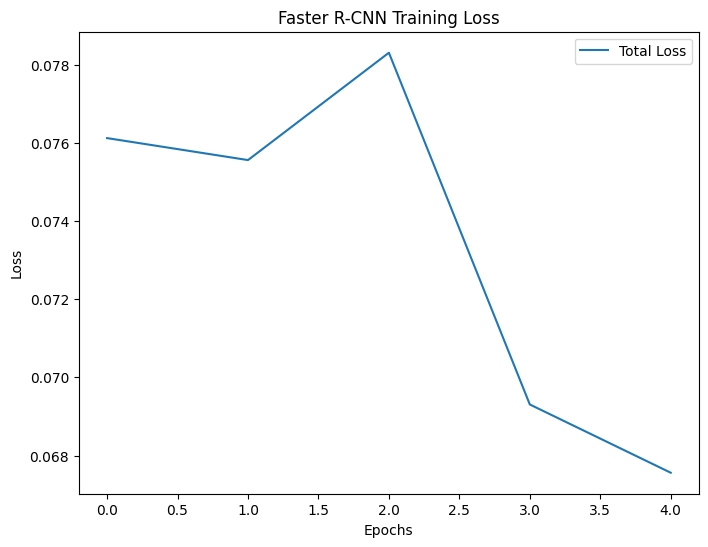

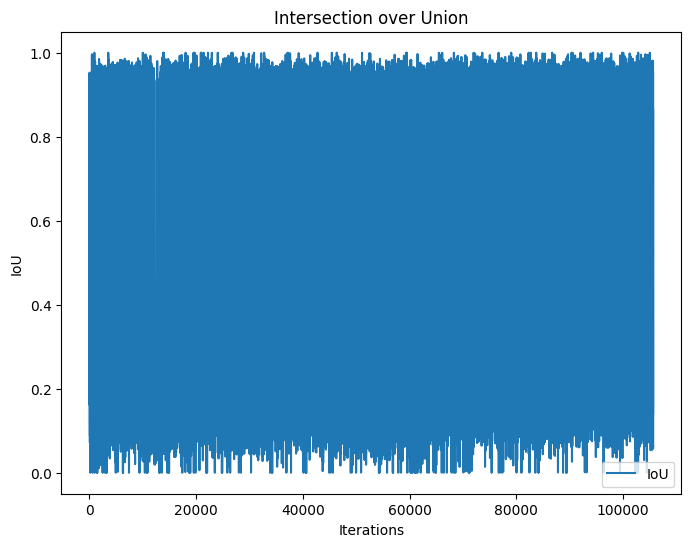

In [ ]:
# Evaluate Faster R-CNN model
model.eval()
true_labels, pred_labels, pred_scores = [], [], []

with torch.no_grad():
    for images, targets in test_loader:
        images = list(image.to(device) for image in images)

        # Debug print to check the structure of targets
        print(f"Raw targets: {targets}")

        new_targets = []
        for target in targets:
            # Debug print to check the structure of each target
            print(f"Individual target: {target}")


        outputs = model(images)

        for output, target in zip(outputs, targets):
            # Iterate over each annotation in the target
            for annotation in target:
                true_labels.append(annotation['category_id'])

            pred_labels.extend(output['labels'].tolist())
            pred_scores.extend(output['scores'].tolist())

# Debug print statements to check lengths of true_labels and pred_labels
print(f"Length of true_labels: {len(true_labels)}")
print(f"Length of pred_labels: {len(pred_labels)}")

# Calculate mAP
def calculate_ap(precision, recall):
    ap = 0
    for i in range(len(precision) - 1):
        ap += (recall[i + 1] - recall[i]) * precision[i + 1]
    return ap

def calculate_mAP(true_labels, pred_labels, pred_scores, num_classes):
    aps = []
    for cls in range(num_classes):
        true_cls = [True if label == cls else False for label in true_labels]
        pred_cls = [True if label == cls else False for label in pred_labels]

        true_positives = [True if t and p else False for t, p in zip(true_cls, pred_cls)]
        false_positives = [True if not t and p else False for t, p in zip(true_cls, pred_cls)]

        # Convert pred_scores to a tensor
        pred_scores_tensor = torch.tensor(pred_scores)

        # Sort true_positives and false_positives alongside pred_scores_tensor
        sorted_indices = torch.argsort(pred_scores_tensor, descending=True)
        sorted_indices_numpy = sorted_indices.numpy()
        true_positives_padded = [true_positives[i] if i < len(true_positives) else False for i in sorted_indices_numpy]
        false_positives_padded = [false_positives[i] if i < len(false_positives) else False for i in sorted_indices_numpy]

        num_true_positives = sum(true_positives)
        num_false_positives = sum(false_positives)

        precision = []
        recall = []
        for i in range(len(true_positives_padded)):
            true_positives_sum = sum(true_positives_padded[:i + 1])
            false_positives_sum = sum(false_positives_padded[:i + 1])

            if num_true_positives == 0:
                recall.append(0)
            else:
                recall.append(true_positives_sum / num_true_positives)

            if true_positives_sum + false_positives_sum > 0:
                precision.append(true_positives_sum / (true_positives_sum + false_positives_sum))
            else:
                precision.append(0)

        ap = calculate_ap(precision, recall)
        aps.append(ap)

    mAP = sum(aps) / len(aps)
    return mAP

mAP = calculate_mAP(true_labels, pred_labels, pred_scores, num_classes)
print(f'mAP: {mAP:.4f}')

# Calculate F1-score, precision, recall, and confusion matrix
if len(true_labels) == len(pred_labels):
    f1 = f1_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='macro')
    recall = recall_score(true_labels, pred_labels, average='macro')
    confusion = confusion_matrix(true_labels, pred_labels)

    print(f'mAP: {mAP:.4f}')
    print(f'F1-score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print('Confusion Matrix:')
    print(confusion)
else:
    print("Error: Length of true_labels and pred_labels does not match. Check your data processing logic.")

# Plot and save metrics
plt.figure(figsize=(8, 6))
plt.plot(total_losses, label='Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Faster R-CNN Training Loss')
plt.legend()
plt.savefig('fasterrcnn_loss.png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(8, 6))
plt.plot(ious, label='IoU')
plt.xlabel('Iterations')
plt.ylabel('IoU')
plt.title('Intersection over Union')
plt.legend()
plt.savefig('fasterrcnn_iou.png', dpi=300, bbox_inches='tight')

plt.figure
